<a href="https://colab.research.google.com/github/SofiaFreiman/Post_Stroke_Epilepsy/blob/main/Post_stroke_epilepsy_cohort_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=e4a85db8529960ecb82987c5f20d1bfb99f8a24daf5d7ee6593f6ce10c8485b3
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

import lifelines
from lifelines import AalenJohansenFitter
from lifelines import KaplanMeierFitter

In [2]:
!gdown --id 1e3KqZj4dKhV6QeF8O4GWZILUdy85Hj0H
!gdown --id 1e1bePGr1g_3nZlJSO79eDIZBn46XX2d2

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1e3KqZj4dKhV6QeF8O4GWZILUdy85Hj0H
To: /content/anonymus_stroke_data.xlsx
100% 195k/195k [00:00<00:00, 74.9MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1e1bePGr1g_3nZlJSO79eDIZBn46XX2d2
To: /content/anonymus_analysis_data.xlsx
100% 99.6k/99.6k [00:00<00:00, 78.7MB/s]


## Preprocessing and cleaning

In [30]:
# Read and merge clinical and laboratory data

df=pd.read_excel("anonymus_stroke_data.xlsx", skiprows=[1,2])
df.rename(columns={'EPS_0-7':'eps', 'EPS_28+':'lps'}, inplace=True)
df=df[df.local_side!=2]
dfg=pd.read_excel("anonymus_analysis_data.xlsx")
df=df.merge(dfg, how='left', on='clinic_numb')
df.head(2)

,paper_number,check_actual,clinic_numb,eps,eps_type,lps,first_ever,cortical_involvement,sex,age,...,trigl,troponin,urea,test,PLT,RBC,WBC,EPS_0-7,EPS_28+,mort_clinic
0,NaN,NaN,4176,0,NaN,0,0,NaN,1,68,...,NaN,NaN,8.2,208.0,208.0,4.86,5.2,0.0,0.0,0.0
1,NaN,NaN,23424,1,1.0,0,0,NaN,0,54,...,2.7,NaN,3.5,175.0,175.0,4.50,8.3,1.0,0.0,0.0


In [31]:
# Stroke recurrency decoded in the clinical data for each follow-up time point

df[[col for col in df.columns if "Recurrent" in col]][:2]

,Recurrent_90,Recurrent_180,Recurrent_365,Recurrent_540
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0


In [32]:
# Prepare "stroke_recurrence" column with number of recurrencies occurred during follow up

df['stroke_recurrence']=df.Recurrent_90.fillna(0)+df.Recurrent_180.fillna(0)+df.Recurrent_365.fillna(0)+df.Recurrent_540.fillna(0)
print(df['stroke_recurrence'].value_counts())
df.stroke_recurrence.replace({2:1}, inplace=True)
print(df.stroke_recurrence.value_counts())

stroke_recurrence
0.0    387
1.0     35
2.0      2
Name: count, dtype: int64
stroke_recurrence
0.0    387
1.0     37
Name: count, dtype: int64


<ipython-input-32-33f5a70bff54>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.stroke_recurrence.replace({2:1}, inplace=True)


In [33]:
# Clinic number is a technical number assigned to each patient in the Hospital's database. The numbers repeat every year and therefore could repeat in this longitudinal data
df.clinic_numb.value_counts()[:5]

,count
clinic_numb,
12254,2
31039,2
17211,2
31059,2
4176,1


In [34]:
# Identify and fix clinic numbers that have duplicates

duplicate_clinics = df['clinic_numb'].value_counts()
duplicate_clinics = duplicate_clinics[duplicate_clinics > 1].index  # Get clinic numbers with duplicates
# Iterate through duplicate clinic numbers and update the second occurrence
for clinic_num in duplicate_clinics:
    indices = df.index[df['clinic_numb'] == clinic_num].tolist()
    if len(indices) > 1:
        df.loc[indices[1], 'clinic_numb'] = int(f"1{clinic_num}")

df.clinic_numb.value_counts()[:5]

,count
clinic_numb,
4176,1
12125,1
28594,1
5199,1
28480,1


In [35]:
# Prepare new columns on strke features required for further analysis

df["general_type"]=df.stroke_subtype.replace({1:0, 2:1, 3:1})
df['secondary_hem']=df.stroke_subtype.replace({2:0, 3:0})
df['motor_seizures']=df.eps_type.replace({1:0, 2:1, 3:1, 4:1})

df['is_ich']=df['stroke_subtype'].replace({1:0,3:0}) ## ICH - 2, other-0
df['is_MCA']=df['isch_local_place'].replace({0:1, 3:1, 4:1}) ## MCA-2, other-1
df['is_watershed']=df['isch_local_place'].replace({0:1,2:1,3:1}) ## left-4, other-1
df['TOAST_1']=df['TOAST'].replace({2:0,3:0,5:0})
df['ischemic']=df.stroke_subtype.replace({1:0, 2:1, 3:1})

pd.crosstab(df.general_type, df.secondary_hem)

secondary_hem,0,1
general_type,,
0,346,14
1,64,0


In [36]:
# Remove unnecessary columns

for_drop=['paper_number','check_actual','weight','adm_date','disch_date','LOC_stimul','LOC_quest','LOC_command','best_gase','visual','facial_palsy',
          'motor_arm','motor_leg','limb_ataxia','sensory','best_lang','dysarthria','extinct_inattent','Euro_score_1','dementia','EPS_-1','Brain_CT/MRI','volume_of_lesion',
          'hemorrage_type','Parenchymal_SAH_location','occlusion','volume_of_lesion.1','Lumbar puncture','systolic','diastolic','pulse','temp','art_lung_vent_1','medications_1',
          'GCS_3','art_lung_vent_3','medications_3','Euro_score_7','medications_7','EEG_7_focal','EEG_7_synchron','medications_28','medications_90',
          'Recurrent_90','Recurrent_180','medications_180','Recurrent_365','medications_365','Recurrent_540','medications_540','NOS3 rs2070744','NOS3 rs1799983',
          'NOS1 rs2293046','NOS1 rs11068428','check','Unnamed: 0','BAS','BE_b','BE_ecf','CO2','Ca','EOS','PCT','GR','HGB','INR','MPV','O2','O2_hem','a_amylase','acid_blood','acid_phosph',
          'albumen','bilirubin_direct','color_blood','creat_kinase','creat_kinase_mv','creatinine','cytosis','d_dimer','ggtp','glu_cerebral','glu_urine','glycohemoglobin','ketone',
          'protein_cerebral','protein_urine','troponin','test','EPS_0-7','EPS_28+']
for i in for_drop:
  if i in df.columns:
    del df[i]
# df=df.drop(for_drop, axis='columns')

In [37]:
df.head(2)

,clinic_numb,eps,eps_type,lps,first_ever,cortical_involvement,sex,age,hosp_days,smoke,...,WBC,mort_clinic,stroke_recurrence,secondary_hem,motor_seizures,is_ich,is_MCA,is_watershed,TOAST_1,ischemic
0,4176,0,NaN,0,0,NaN,1,68,38,0,...,5.2,0.0,0.0,0,NaN,0,2,1,0.0,0
1,23424,1,1.0,0,0,NaN,0,54,16,0,...,8.3,0.0,0.0,0,0.0,0,2,1,0.0,0


Prepare "date" columns from the follow-up intervals

In [38]:
date_dict={-1:14, 0:28, 1:90, 2:180, 3:356, 4:540, 5:720}
mort_date_dict={-1:0,0:1, 1:3, 2:7, 3:28, 4:90, 5:180, 6:356, 7:540, 8:720}

def lps_date(x):
    for num,value in enumerate(x):
        if value == 1:
            return(pd.Series([date_dict[num],1]))
        elif value == 999:
            return(pd.Series([date_dict[num],0]))
        elif value == 0 and num == 5:
            return(pd.Series([date_dict[num],0]))
def mort_date(x):
    for num,value in enumerate(x):
        if value == 0 and num == 8 :
            return(pd.Series([mort_date_dict[num],0]))
        elif value == 1:
            return(pd.Series([mort_date_dict[num],1]))
        elif value == 999:
            return(pd.Series([mort_date_dict[num],0]))

def outcome_date(x):
  if x['outcome'] == 0 :
    return(720)
  elif x['outcome'] == 1 or x['outcome'] == 3:
    return(x['LPS_date'])
  else:
    return(x['mort_date'])

In [39]:
eps = ['EPS_0', 'EPS_3', 'EPS_7']
lps = ['EPS_28', 'EPS_90', 'EPS_180', 'EPS_365', 'EPS_540', 'EPS_720']
mortality = ['mortality_1','mortality_3','mortality_7','mortality_28','mortality_90','mortality_180','mortality_365','mortality_540','mortality_720']

sub_lps = df[lps].fillna(999)
sub_lps[['LPS_date','LPS_outcome']] = sub_lps.apply(lps_date,axis=1) # Late post-stroke seizure "date"/follow-up interval

sub_mort = df[mortality].fillna(999)
sub_mort[['mort_date','mort_outcome']] = sub_mort.apply(mort_date,axis=1) # Mortality "date"/follow-up interval

subset = pd.DataFrame()
subset['LPS_date'] = sub_lps.LPS_date
subset['LPS_outcome'] = sub_lps.LPS_outcome
subset['mort_date'] = sub_mort.mort_date
subset['mort_outcome'] = sub_mort.mort_outcome.replace({1:2})
subset['outcome'] = subset['LPS_outcome']+subset['mort_outcome']

subset['date'] = subset[['outcome','LPS_date','mort_date']].apply(outcome_date, axis = 1)

df['date']=subset.date
df['outcome']=subset.outcome.replace({3:1})
df["LPS_date"]=subset.LPS_date
df['LPS_outcome']=subset.LPS_outcome
df['mort_date']=subset.mort_date
df['mort_outcome']=subset.mort_outcome

df[["date", 'outcome', 'LPS_date', "LPS_outcome", 'mort_date', 'mort_outcome']].head(3)

,date,outcome,LPS_date,LPS_outcome,mort_date,mort_outcome
0,720,0,720,0,720,0
1,720,0,720,0,720,0
2,28,2,28,0,28,2


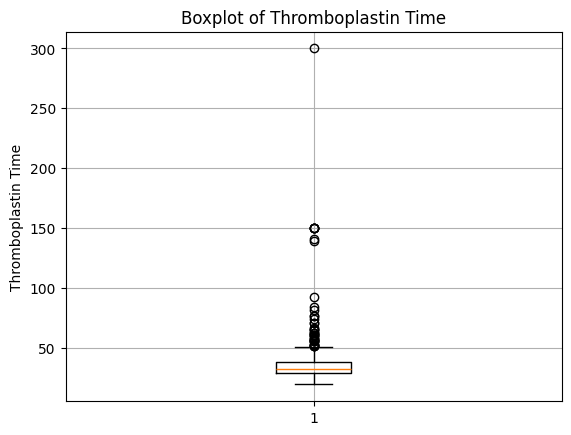

In [11]:
plt.boxplot(df['thromboplastin_time'].dropna())
plt.title('Boxplot of Thromboplastin Time')
plt.ylabel('Thromboplastin Time')
plt.grid(True)

In [40]:
# After contacting with clinicians, decided to remove this laboratory indice as probably measured incorrectly
df.loc[df[df.thromboplastin_time>200].index[0], 'thromboplastin_time']=np.nan

##Univariable analysis for PSE in IS
 For Ischemic stroke

In [13]:
# Normality test for laboratory data
lab_data = ['Cl','HCT','K','LYM','MON','NEU','Na','alt','ast','bilirubin_total','cholesterol','extra_low_den_chol','fibrinogen','glu_blood',
         'high_den_chol','ldg_total','low_den_chol','protein_blood','prothrombin_time','thrombin_time','thromboplastin_time','trigl','urea','PLT','RBC','WBC']

df_ish = df[df.general_type == 0]
ls = []
subset = df_ish[lab_data]
for i in subset.columns:
    parameter = subset[i].dropna()
    parameter = (parameter-parameter.mean())/parameter.std()
    ls.append([i, st.kstest(parameter, 'norm')[1], st.kstest(parameter, 'norm')[1]>0.05,
               st.shapiro(parameter)[1], st.shapiro(parameter)[1]>0.05])
ls_df=pd.DataFrame(ls, columns=['predictor', "Kolm_Smirn_pval", 'Norm_KS', 'Shapiro_pval', 'Norm_Sh'])
# ls_df.to_excel('Normallity_test.xlsx')

In [14]:
for_chi=['eps','motor_seizures','sex','first_ever','smoke','alcohol','obesity','dyslipidemia','diabetes','arhythmia','IM','IchHD',
         'TOAST','local_side','isch_local_place','eps_type','cortical_involvement','secondary_hem']
for_mw1=['age','hypertension','NIHSS_1','NIHSS_3','NIHSS_7',
       'EPS_7','Barthel_28','Rankin_28','NIHSS_28','NIHSS_90','Barthel_90','Rankin_90','NIHSS_180','Barthel_180',
        'Rankin_180','NIHSS_365','Barthel_365','Rankin_365','NIHSS_540','Barthel_540','Rankin_540']
for_mw=['age','hypertension','NIHSS_1','GCS_1','NIHSS_3','NIHSS_7',
       'EPS_7','Barthel_28','Rankin_28','NIHSS_28','NIHSS_90','Barthel_90','Rankin_90','NIHSS_180','Barthel_180',
        'Rankin_180','NIHSS_365','Barthel_365','Rankin_365','NIHSS_540','Barthel_540','Rankin_540','Cl','K','MON','Na',
        'alt','ast','bilirubin_total','extra_low_den_chol','glu_blood',
       'ldg_total','prothrombin_time','thrombin_time','thromboplastin_time','trigl','urea',
        'PLT','RBC','WBC']
for_stu=['age','HCT','LYM','NEU','cholesterol','fibrinogen','high_den_chol','low_den_chol','protein_blood']

In [15]:
# Calculate univariable statistics

df_norma=df_ish[df_ish['lps']==0]
df_lps=df_ish[df_ish['lps']==1]

## Chi-square test
ls=[]
for i in for_chi:
    b=pd.crosstab(df_ish.lps, df_ish[i])
    a=st.chi2_contingency(b)[1]
    prc_norm=100*len(df_norma[df_norma[i]==1])/len(df_norma)
    prc_lps=100*len(df_lps[df_lps[i]==1])/len(df_lps)
    ls.append([i, len(df_norma[i].dropna()), b[1][0], prc_norm, len(df_lps[i].dropna()), b[1][1], prc_lps, a])

ls_df=pd.DataFrame(ls, columns=['predictor', 'n Norm', 'n yes Norm', "% yes Norm",
                                "n PSE", 'n yes PSE', '% yes PSE', 'p-value'])
# ls_df.to_excel("stats_chi.xlsx")

# Mann-Whitney U-test
ls=[]
for i in for_mw:
    a=st.mannwhitneyu(df_norma[i].dropna(), df_lps[i].dropna())
    ls.append([i, len(df_norma[i].dropna()), len(df_lps[i].dropna()), df_norma[i].mean(), df_norma[i].std(),
                                                df_lps[i].mean(), df_lps[i].std(), a[1]])

ls_df=pd.DataFrame(ls, columns=['predictor',"n Norm", "n PSE", 'mean Norm', 'std Norm', 'mean PSE', 'std PSE', 'p-value'])
# ls_df.to_excel("stats_mv.xlsx")

# Students T-test
ls=[]
for i in for_stu:
    a=st.ttest_ind(df_norma[i], df_lps[i], nan_policy='omit')
    ls.append([i, len(df_norma[i].dropna()), len(df_lps[i].dropna()), df_norma[i].mean(), df_norma[i].std(),
               df_lps[i].mean(), df_lps[i].std(), a[1]])

ls_df=pd.DataFrame(ls, columns=['predictor',"n Norm", "n PSE", 'mean Norm', 'std Norm', 'mean PSE', 'std PSE', 'p-value'])
# ls_df.to_excel("stats_stu.xlsx")

In [16]:
# Calculate quantiles

df_norma=df_ish[df_ish['lps']==0]
df_lps=df_ish[df_ish['lps']==1]

q=['NIHSS_1', 'GCS_1', 'Barthel_28', 'Rankin_28', 'NIHSS_28']
ls=[]
for i in q:
    ls.append([i, df_norma[i].median(), df_norma[i].quantile([0.25, 0.75]), df_lps[i].median(), df_lps[i].quantile([0.25, 0.75])])
ls_df=pd.DataFrame(ls, columns=['predictor', 'Norm median', 'Norm q1-q3', 'PSE median', 'PSE q1-q3'])
# ls_df.to_excel('stats_add.xlsx')

df_ish['hypertension_general']=df_ish.hypertension.replace({1:0,3:2})
b=pd.crosstab(df_ish.lps, df_ish.hypertension_general)
print(b, st.chi2_contingency(b))

hypertension_general   0    2
lps                          
0                     34  303
1                      5   18 Chi2ContingencyResult(statistic=1.9393300147908836, pvalue=0.16374129851410674, dof=1, expected_freq=array([[ 36.50833333, 300.49166667],
       [  2.49166667,  20.50833333]]))


<ipython-input-16-163bbd83aa56>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ish['hypertension_general']=df_ish.hypertension.replace({1:0,3:2})


In [ ]:
# Univariable Cox regression for bilirubin

subset=df_ish[['bilirubin_total','LPS_date','LPS_outcome']].dropna()
cph = lifelines.CoxPHFitter()
cph.fit(subset, 'LPS_date', 'LPS_outcome')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 213 total observations, 196 right-censored observations>
             duration col = 'LPS_date'
                event col = 'LPS_outcome'
      baseline estimation = breslow
   number of observations = 213
number of events observed = 17
   partial log-likelihood = -88.70
         time fit was run = 2022-05-23 14:22:20 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
bilirubin_total   0.02       1.02       0.02            -0.01             0.05                 0.99                 1.05

                  cmp to    z    p   -log2(p)
covariate                                    
bilirubin_total     0.00 1.39 0.17       2.59
---
Concordance = 0.60
Partial AIC = 179.41
log-likelihood ratio test = 1.31 on 1 df
-log2(p) of ll-ratio test = 1.99

In [ ]:
subset=df[['extra_low_den_chol','LPS_date','LPS_outcome']].dropna()
cph = lifelines.CoxPHFitter()
cph.fit(subset, 'LPS_date', 'LPS_outcome')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 145 total observations, 135 right-censored observations>
             duration col = 'LPS_date'
                event col = 'LPS_outcome'
      baseline estimation = breslow
   number of observations = 145
number of events observed = 10
   partial log-likelihood = -46.46
         time fit was run = 2022-05-25 12:55:26 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
extra_low_den_chol  -1.91       0.15       1.25            -4.36             0.54                 0.01                 1.72

                     cmp to     z    p   -log2(p)
covariate                                        
extra_low_den_chol     0.00 -1.53 0.13       2.98
---
Concordance = 0.64
Partial AIC = 94.91
log-likelihood ratio test = 3.38 on 1 df
-log2(p) of ll-ratio test = 3.92

##PSE incidence

/usr/local/lib/python3.11/dist-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


(-0.01, 0.203)

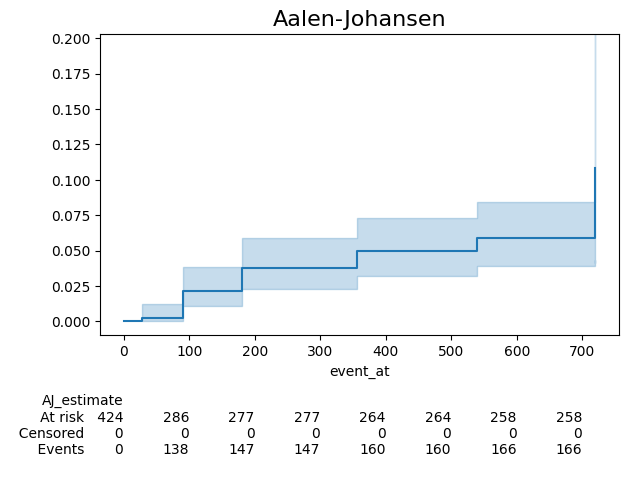

In [30]:
aj=AalenJohansenFitter()
aj.fit(durations=df.date, event_observed=df.outcome, event_of_interest=1)
aj.plot(at_risk_counts=True, legend=None)
plt.title("Aalen-Johansen", fontsize=16)
plt.ylim(-0.01, 0.203)
# plt.savefig('fig.jpg', bbox_inches='tight', dpi=600)

(-0.01, 0.203)

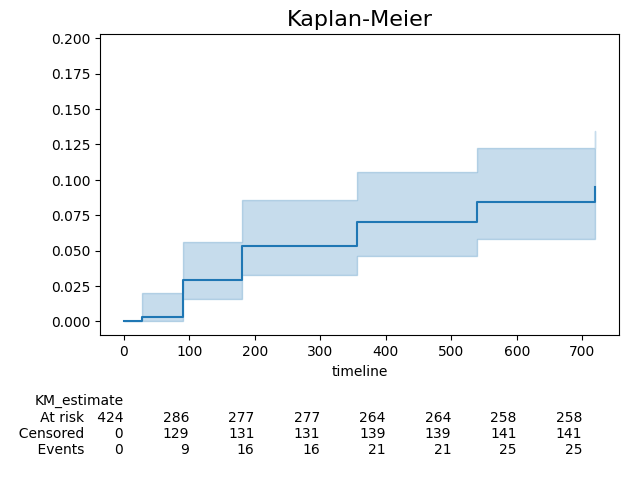

In [31]:
km = KaplanMeierFitter()
km.fit(durations=df.date, event_observed=df.outcome.replace({3:1, 2:0}))
km.plot_cumulative_density(legend=None)
km.plot_survival_function(at_risk_counts=True, legend=None)
plt.title("Kaplan-Meier", fontsize=16)
plt.ylim(-0.01, 0.203)
# plt.savefig('fig.jpg', bbox_inches='tight', dpi=600)

In [32]:
# Cumulative demcity from both regressions

cum_den=pd.DataFrame()
cum_den["KM"]=km.cumulative_density_
q=aj.cumulative_density_
q.reset_index(inplace=True)
q.event_at=q.event_at.round(0)
q=q.groupby('event_at')['CIF_1'].mean()
cum_den['AJ'] = q
cum_den

,KM,AJ
timeline,,
0.0,0.000000,0.000000
3.0,0.000000,0.000000
7.0,0.000000,0.000000
28.0,0.002793,0.001279
90.0,0.029474,0.013607
180.0,0.053229,0.028564
356.0,0.070318,0.043541
540.0,0.084404,0.055031
720.0,0.095051,0.078962


#Multivariable predictors (Cox)

In [33]:
## Multivariable Cox Proportional Hazard Model for Late post-stroke seizures predictors

df_ish=df[df.mortality_90==0]
subset=df_ish[['general_type','NIHSS_1','TOAST_1','is_watershed','obesity','Barthel_28','thromboplastin_time','LPS_date','LPS_outcome']].dropna()
cph = lifelines.CoxPHFitter()
cph.fit(subset, 'LPS_date', 'LPS_outcome')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 231 total observations, 211 right-censored observations>
             duration col = 'LPS_date'
                event col = 'LPS_outcome'
      baseline estimation = breslow
   number of observations = 231
number of events observed = 20
   partial log-likelihood = -100.32
         time fit was run = 2025-01-26 09:52:07 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
general_type         0.36      1.43      0.65           -0.92            1.64                0.40                5.14
NIHSS_1             -0.04      0.96      0.07           -0.17            0.09                0.85                1.09
TOAST_1              0.16      1.17      0.66           -1.14            1.45                0.32                4.27
is_watershed         0.57      1.76      0.22            0.13            1.00                1.14                2.72
obesity              0.71      2.04      0.46           -0.19            1.62                0.82                5.03
Barthel_28          -0.02      0.98      0.01           -0.05            0.01                0.95                1.01
thromboplastin_time  0.02      1.02      0.01            0.01            0.04                1.01                1.04

                     cmp to     z    p  -log2(p)
covariate                                       
general_type           0.00  0.55 0.58      0.77
NIHSS_1                0.00 -0.59 0.55      0.85
TOAST_1                0.00  0.23 0.81      0.30
is_watershed           0.00  2.55 0.01      6.54
obesity                0.00  1.54 0.12      3.01
Barthel_28             0.00 -1.44 0.15      2.74
thromboplastin_time    0.00  2.75 0.01      7.41
---
Concordance = 0.67
Partial AIC = 214.65
log-likelihood ratio test = 14.75 on 7 df
-log2(p) of ll-ratio test = 4.67

In [17]:
subset=df[['general_type','NIHSS_1','TOAST_1','is_watershed','obesity','Barthel_28','thromboplastin_time','date','outcome']]
subset.to_csv('for_FG.csv')

# Fine and Gray model
Fine and Gray model was a suggestion from one of the reviewers to avoid mortality bias. \
To date of the review process there is no implementation of Fine and Gray model in python. \
The Fine and Gray regression was done using R package "survival"

In [41]:
!pip install anndata2ri==1.1 rpy2==3.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314971 sha256=049fdd5d9baccb1dace062149b6d1655d07a86e4a6e062646f1ec7e8cb367301
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.17
    Uninstalling rpy2-3.5.17:
      Successfully uninstalled rpy2-3.5.17


In [18]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [19]:
%%R
install.packages("survival")
library(survival)

In [24]:
%%R
df=read.csv('for_FG.csv')
df$outcome_lps = replace(df$outcome, df$outcome==2, 0)
km <- survfit(Surv(date, outcome_lps) ~ 1, data=df)
summary(km)

Call: survfit(formula = Surv(date, outcome_lps) ~ 1, data = df)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
   28    358       1    0.997 0.00279        0.992        1.000
   90    299       8    0.971 0.00969        0.952        0.990
  180    286       7    0.947 0.01296        0.922        0.973
  356    277       5    0.930 0.01481        0.901        0.959
  540    264       4    0.916 0.01618        0.884        0.948
  720    258       3    0.905 0.01712        0.872        0.939


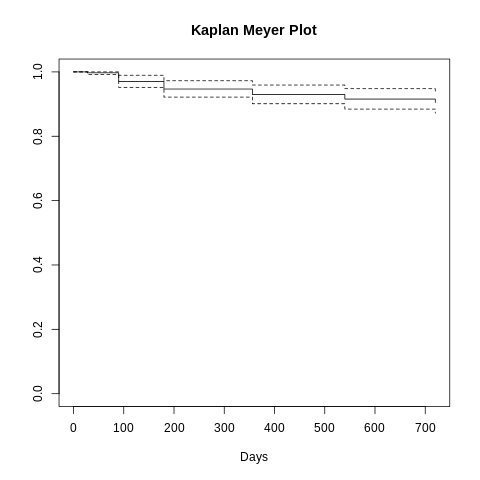

In [25]:
%%R
plot(km, xlab="Days", main = 'Kaplan Meyer Plot')

In [ ]:
subset=df_ish[['NIHSS_1','motor_seizures','TOAST_1','is_watershed','Barthel_28','LPS_date','LPS_outcome']].dropna()
cph = lifelines.CoxPHFitter()
cph.fit(subset, 'LPS_date', 'LPS_outcome')
cph.print_summary()

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column TOAST_1 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['LPS_outcome'].astype(bool)
>>> print(df.loc[events, 'TOAST_1'].var())
>>> print(df.loc[~events, 'TOAST_1'].var())

A very low variance means that the column TOAST_1 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.264. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation

<lifelines.CoxPHFitter: fitted with 41 total observations, 38 right-censored observations>
             duration col = 'LPS_date'
                event col = 'LPS_outcome'
      baseline estimation = breslow
   number of observations = 41
number of events observed = 3
   partial log-likelihood = -6.66
         time fit was run = 2022-05-23 14:58:55 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
NIHSS_1          0.10       1.11       0.17            -0.22             0.43                 0.80                 1.53
motor_seizures   1.96       7.08       1.36            -0.71             4.62                 0.49               101.70
TOAST_1        -12.19       0.00    2940.60         -5775.66          5751.29                 0.00                  inf
is_watershed     0.90       2.47       0.64            -0.35             2.16                 0.70                 8.66
Barthel_28      -0.04       0.96       0.03            -0.11             0.02                 0.90                 1.02

                 cmp to     z    p   -log2(p)
covariate                                    
NIHSS_1            0.00  0.61 0.54       0.89
motor_seizures     0.00  1.44 0.15       2.74
TOAST_1            0.00 -0.00 1.00       0.00
is_watershed       0.00  1.41 0.16       2.66
Barthel_28         0.00 -1.30 0.19       2.36
---
Concordance = 0.93
Partial AIC = 23.31
log-likelihood ratio test = 8.35 on 5 df
-log2(p) of ll-ratio test = 2.86

#In-hospital period (all)
ANOVA analysis for in-hospital neurological recovery

In [49]:
!pip uninstall scipy -y
!pip uninstall pingouin -y
!pip install pingouin

Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 14.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.1 which is incompatible.


In [50]:
import pingouin as pg
from statsmodels.stats import multitest

In [ ]:
nihss=['NIHSS_1','NIHSS_3','NIHSS_7','NIHSS_28','lps','clinic_numb']
df_nihss=df[df.mortality_28==0][nihss]
# df_nihss=df[nihss]
print(len(df_nihss))

df_nihss=pd.wide_to_long(df_nihss, stubnames='NIHSS_', i='clinic_numb', j='days')
df_nihss.rename(columns={'NIHSS_':'NIHSS'}, inplace=True)
df_nihss.reset_index(inplace=True)
pg.mixed_anova(data=df_nihss, dv='NIHSS', subject='clinic_numb', within='days', between='lps')

/usr/local/lib/python3.10/dist-packages/pingouin/parametric.py:1568: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,lps,578.211055,1,297,578.211055,6.842913,9.354223e-03,NaN,0.022521,NaN,NaN,NaN,NaN
1,days,2637.480769,3,891,879.160256,277.926027,2.665552e-127,3.559413e-101,0.483412,0.791995,False,0.692304,6.318824e-22
2,Interaction,24.779016,3,891,8.259672,2.611103,5.025342e-02,NaN,0.008715,NaN,NaN,NaN,NaN


In [ ]:
pg.pairwise_ttests(dv='NIHSS', within='days', between='lps',subject='clinic_numb', data=df_nihss)

,Contrast,days,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,days,-,1.0,3.0,True,True,6.661221,298.000000,two-sided,1.309006e-10,5.17e+07,0.160983
1,days,-,1.0,7.0,True,True,15.039686,298.000000,two-sided,1.991695e-38,1.215e+35,0.413392
2,days,-,1.0,28.0,True,True,21.354281,298.000000,two-sided,5.036909e-62,3.029e+58,0.816937
3,days,-,3.0,7.0,True,True,11.185486,298.000000,two-sided,1.744072e-24,2.051e+21,0.263109
4,days,-,3.0,28.0,True,True,19.057849,298.000000,two-sided,1.666688e-53,1.062e+50,0.672215
5,days,-,7.0,28.0,True,True,13.336282,298.000000,two-sided,3.891245e-32,7.297e+28,0.383090
6,lps,-,0.0,1.0,False,True,-2.206129,30.777402,two-sided,3.497132e-02,1.82,-0.517957
7,days * lps,1,0,1,False,True,-1.595471,32.154839,two-sided,1.203902e-01,0.648,-0.331577
8,days * lps,3,0,1,False,True,-2.484231,31.199972,two-sided,1.855410e-02,3.251,-0.559522
9,days * lps,7,0,1,False,True,-2.405202,30.245273,two-sided,2.248300e-02,2.738,-0.599094


In [ ]:
# FDR p-value correction
tmp = pg.pairwise_ttests(dv='NIHSS', within='days', between='lps',subject='clinic_numb', data=df_nihss)
pval = tmp[tmp.Contrast == "days * lps"]['p-unc'].to_list()
multitest.multipletests(pvals=pval, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

(array([False,  True,  True, False]),
 array([0.1203902 , 0.044966  , 0.044966  , 0.10894992]),
 0.012741455098566168,
 0.0125)

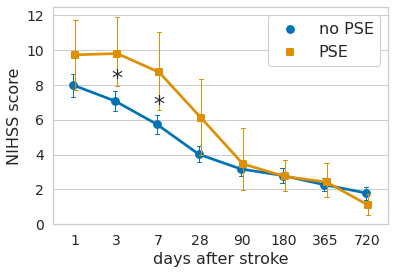

In [ ]:
df_nihss['lps_label']=df_nihss['lps'].replace({0:'no PSE', 1:'PSE'})
sns.set()
sns.set_style('whitegrid')
sns.pointplot(data=df_nihss, x='days', y='NIHSS', hue='lps_label', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, palette='colorblind')
plt.text(0.88, 8, "*", fontsize=22)
plt.text(1.88, 6.5, "*", fontsize=22)
plt.xlabel('days after stroke', fontsize=16)
plt.ylabel('NIHSS score', fontsize=16)
plt.legend(fontsize=16, framealpha=1)
plt.ylim(0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('NIHSS dynamics in acute stroke period', fontsize=18)

plt.savefig('nihss_in_hosp.jpg', bbox_inches='tight', dpi=600)

In [ ]:
set(df_nihss.days)

{1, 3, 7, 28, 90, 180, 365, 720}

299


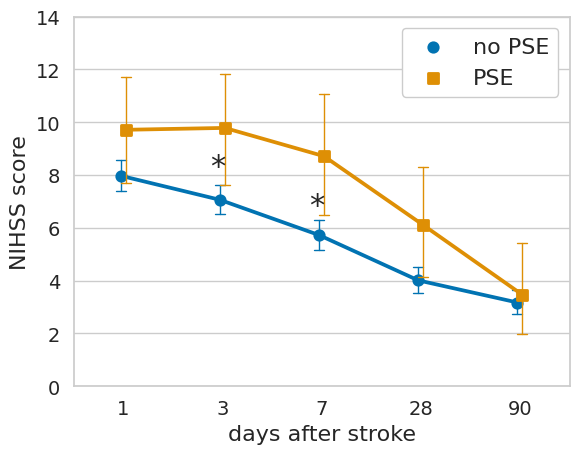

In [ ]:
nihss=['NIHSS_1','NIHSS_3','NIHSS_7','NIHSS_28','NIHSS_90','lps','clinic_numb'] #'NIHSS_180','NIHSS_365','NIHSS_720',
df_nihss=df[df.mortality_28==0][nihss]
# df_nihss=df[nihss]
print(len(df_nihss))

df_nihss=pd.wide_to_long(df_nihss, stubnames='NIHSS_',i='clinic_numb',j='days')
df_nihss.rename(columns={'NIHSS_':'NIHSS'}, inplace=True)
df_nihss.reset_index(inplace=True)

df_nihss['lps_label']=df_nihss['lps'].replace({0:'no PSE', 1:'PSE'})
sns.set()
sns.set_style('whitegrid')
sns.pointplot(data=df_nihss, x='days', y='NIHSS', hue='lps_label', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, palette='colorblind')
plt.text(0.88, 8, "*", fontsize=22)
plt.text(1.88, 6.5, "*", fontsize=22)
plt.xlabel('days after stroke', fontsize=16)
plt.ylabel('NIHSS score', fontsize=16)
plt.legend(fontsize=16, framealpha=1)
plt.ylim(0, 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title('NIHSS dynamics in acute stroke period', fontsize=18)

plt.savefig('figure_3.eps', bbox_inches='tight', dpi=600)

#Does thrompolactine associate with hemorrhagic transformation?

In [ ]:
print("N =", len(df[df.secondary_hem==0]['thromboplastin_time'].dropna()), ";", "mean =", round(df[df.secondary_hem==0]['thromboplastin_time'].dropna().mean(), 1),";",
      'SD =', round(df[df.secondary_hem==0]['thromboplastin_time'].dropna().std(), 1))
print("N =", len(df[df.secondary_hem==1]['thromboplastin_time'].dropna()),";", "mean =", round(df[df.secondary_hem==1]['thromboplastin_time'].dropna().mean(), 1),";",
      'SD =', round(df[df.secondary_hem==1]['thromboplastin_time'].dropna().std(), 1))
print('p-value =', round(st.mannwhitneyu(df[df.secondary_hem==0]['thromboplastin_time'].dropna(), df[df.secondary_hem==1]['thromboplastin_time'].dropna())[1], 3))

N = 338 ; mean = 37.8 ; SD = 19.4
N = 13 ; mean = 34.5 ; SD = 10.2
p-value = 0.445


#ES through NIHSS at admission

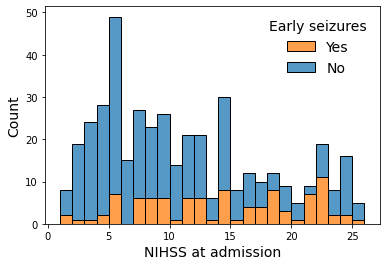

In [ ]:
df1=df.rename(columns={'eps':'ES'})
df1.ES.replace({0:'No', 1:'Yes'}, inplace=True)
sns.histplot(data=df1, x='NIHSS_1', hue='ES', multiple='stack', bins=25)
plt.ylabel("Count", fontsize=14)
plt.xlabel('NIHSS at admission', fontsize=14)
plt.legend(['Yes','No'], title= 'Early seizures', frameon=False, loc='upper right', fontsize=14, title_fontsize=14)
plt.savefig('NIHSS_ES.jpg', bbox_inches='tight', dpi=600)

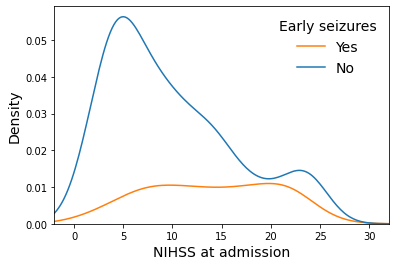

In [ ]:
sns.kdeplot(data=df, x='NIHSS_1', hue='eps')
plt.xlabel('NIHSS at admission', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(-2,32)
plt.legend(['Yes','No'], title= 'Early seizures', frameon=False, loc='upper right', fontsize=14, title_fontsize=14)
plt.savefig('NIHSS_ES_kde.jpg', bbox_inches='tight', dpi=600)

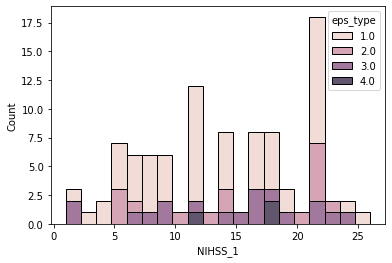

In [ ]:
sns.histplot(data=df[df.eps==1], x='NIHSS_1', hue='eps_type', multiple='stack', bins=20)

#Figures

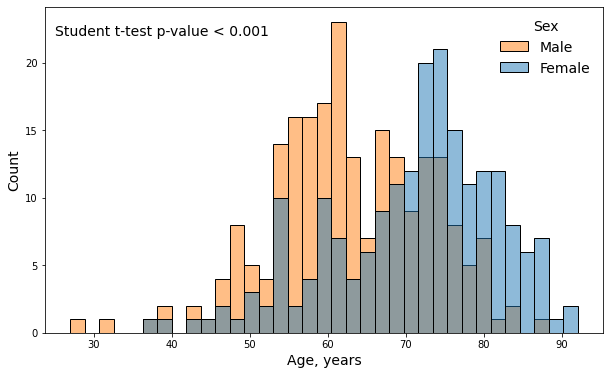

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='sex', bins=35)
plt.ylabel("Count", fontsize=14)
plt.xlabel('Age, years', fontsize=14)
plt.legend(['Male','Female'], title= 'Sex', frameon=False, loc='upper right', fontsize=14, title_fontsize=14)
plt.text(25, 22, "Student t-test p-value < 0.001", fontsize=14)
plt.savefig('Age_sex.jpg', bbox_inches='tight', dpi=600)

In [ ]:
st.ttest_ind(df[df.sex==0]['age'], df[df.sex==1]['age'], nan_policy='omit')

Ttest_indResult(statistic=8.041913768880766, pvalue=9.012064414582752e-15)

# Early seizure predictors: Logistic regression

In [ ]:
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [ ]:
df_isch = df[df.ischemic==0]

In [ ]:
for_chi=['secondary_hem','sex','first_ever','smoke','alcohol','obesity','dyslipidemia','diabetes','arhythmia','IM','IchHD',
         'local_side','isch_local_place','stroke_recurrence','cortical_involvement', 'TOAST']
for_mw=['age','hypertension','NIHSS_1','GCS_1','NIHSS_3','NIHSS_7',
       'EPS_7','Barthel_28','Rankin_28','NIHSS_28','NIHSS_90','Barthel_90','Rankin_90','NIHSS_180','Barthel_180',
        'Rankin_180','NIHSS_365','Barthel_365','Rankin_365','NIHSS_540','Barthel_540','Rankin_540','Cl','K','MON','Na',
        'alt','ast','bilirubin_total','extra_low_den_chol','glu_blood',
       'ldg_total','prothrombin_time','thrombin_time','thromboplastin_time','trigl','urea',
        'PLT','RBC','WBC']
for_stu=['HCT','LYM','NEU','cholesterol','fibrinogen','high_den_chol','low_den_chol','protein_blood']

In [ ]:
df_norma=df_isch[df_isch['eps']==0]
df_eps=df_isch[df_isch['eps']==1]
print(len(df_norma))
print(len(df_eps))
ls = []
for i in for_chi:
    b=pd.crosstab(df.eps, df[i])
    a=st.chi2_contingency(b)[1]
    prc_norm=100*b[1][0]/len(df_norma)
    prc_eps=100*b[1][1]/len(df_eps)
    ls.append([i, b[0][0], b[1][0], prc_norm, b[0][1], b[1][1], prc_eps, a])

ls_df = pd.DataFrame(ls, columns=['predictor', 'n Norm', 'n yes Norm', "% yes Norm",
                                "n ES", 'n yes ES', '% yes ES', 'p-value'])
ls_df.to_excel("stats_chi.xlsx")

ls = []
for i in for_mw:
    a = st.mannwhitneyu(df_norma[i].dropna(), df_eps[i].dropna())
    ls.append([i, len(df_norma[i].dropna()), len(df_eps[i].dropna()), df_norma[i].mean(), df_norma[i].std(),
                                                df_eps[i].mean(), df_eps[i].std(), a[1]])

ls_df = pd.DataFrame(ls, columns=['predictor',"n Norm", "n ES", 'mean Norm', 'std Norm', 'mean ES', 'std ES', 'p-value'])
ls_df.to_excel("stats_mv.xlsx")

ls = []
for i in for_stu:
    a = st.ttest_ind(df_norma[i], df_eps[i], nan_policy='omit')
    ls.append([i, len(df_norma[i].dropna()), len(df_eps[i].dropna()), df_norma[i].mean(), df_norma[i].std(),
               df_eps[i].mean(), df_eps[i].std(), a[1]])

ls_df = pd.DataFrame(ls, columns=['predictor',"n Norm", "n ES", 'mean Norm', 'std Norm', 'mean ES', 'std ES', 'p-value'])
ls_df.to_excel("stats_stu.xlsx")

285
75


In [ ]:
subset = df_isch[['eps', 'NIHSS_1', 'secondary_hem', 'arhythmia', 'IchHD']]
y, X = dmatrices( 'eps ~ NIHSS_1+secondary_hem+arhythmia', data=subset, return_type='dataframe')
mod = sm.Logit(y, X)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.468876
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    eps   No. Observations:                  360
Model:                          Logit   Df Residuals:                      356
Method:                           MLE   Df Model:                            3
Date:                Thu, 02 Jun 2022   Pseudo R-squ.:                 0.08376
Time:                        17:38:38   Log-Likelihood:                -168.80
converged:                       True   LL-Null:                       -184.23
Covariance Type:            nonrobust   LLR p-value:                 9.088e-07
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.5936      0.304     -8.526      0.000      -3.190      -1.997
NIHSS_1           0.

In [ ]:
ls = []
ls.append(['NIHSS_1', np.exp(0.0798), "0.000", np.exp(0.039), np.exp(0.121)])
ls.append(['secondary_hem', np.exp(1.2374), 0.034, np.exp(0.094), np.exp(2.381)])
ls.append(['arhythmia', np.exp(0.7351), 0.008, np.exp(0.194), np.exp(1.276)])
ls_df=pd.DataFrame(ls, columns=['predictor', 'OR', "p_val", 'lower CI', 'upper CI'])
ls_df.to_excel('stats3.xlsx')

#Survival

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

          Early seizures
timeline                
0.0             1.000000
3.0             0.927835
7.0             0.762887
28.0            0.515464
90.0            0.494845
180.0           0.484317
356.0           0.473788
720.0           0.440733
          Without ES
timeline            
0.0         1.000000
3.0         0.966361
7.0         0.868502
28.0        0.761468
90.0        0.752294
180.0       0.749133
356.0       0.723738
540.0       0.717334
720.0       0.646881


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
   event_onserve_A = 1      0
2      2
3      0
14     0
16     0
      ..
407    0
413    2
414    0
419    0
422    2
Name: mort_outcome, Length: 97, dtype: int64
   event_observe_B = 0      0
4      0
5      2
6      0
7      0
      ..
426    0
427    0
428    2
429    2
430    0
Name: mort_outcome, Length: 327, dtype: int64
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          20.87 <0.005     17.63

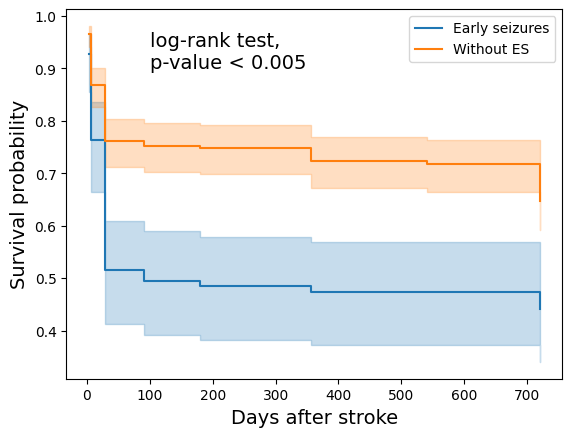

In [ ]:
df_es=df[df.eps==1]
df_norm=df[df.eps==0]

KMF=lifelines.KaplanMeierFitter()
KMF.fit(durations=df_es.mort_date, event_observed=df_es.mort_outcome, label='Early seizures')
KMF.timeline=KMF.timeline[1:]
KMF.plot()
#KMF.plot_cumulative_density()
print(KMF.survival_function_)
#print(KMF.confidence_interval_)

KMF=lifelines.KaplanMeierFitter()
KMF.fit(durations=df_norm.mort_date, event_observed=df_norm.mort_outcome, label='Without ES')
KMF.timeline=KMF.timeline[1:]
KMF.plot()
# KMF.plot_cumulative_density()
print(KMF.survival_function_)
# #print(KMF.confidence_interval_)

plt.xlabel('Days after stroke', fontsize=14)
plt.ylabel('Survival probability', fontsize=14)
plt.text(100, 0.9, "log-rank test,\np-value < 0.005", fontsize = 14)

logrank=logrank_test(durations_A=df_es.mort_date, durations_B=df_norm.mort_date, event_onserve_A=df_es.mort_outcome, event_observe_B=df_norm.mort_outcome)
logrank.print_summary()
plt.savefig('SuppFigure2.png', bbox_inches='tight', dpi=600)

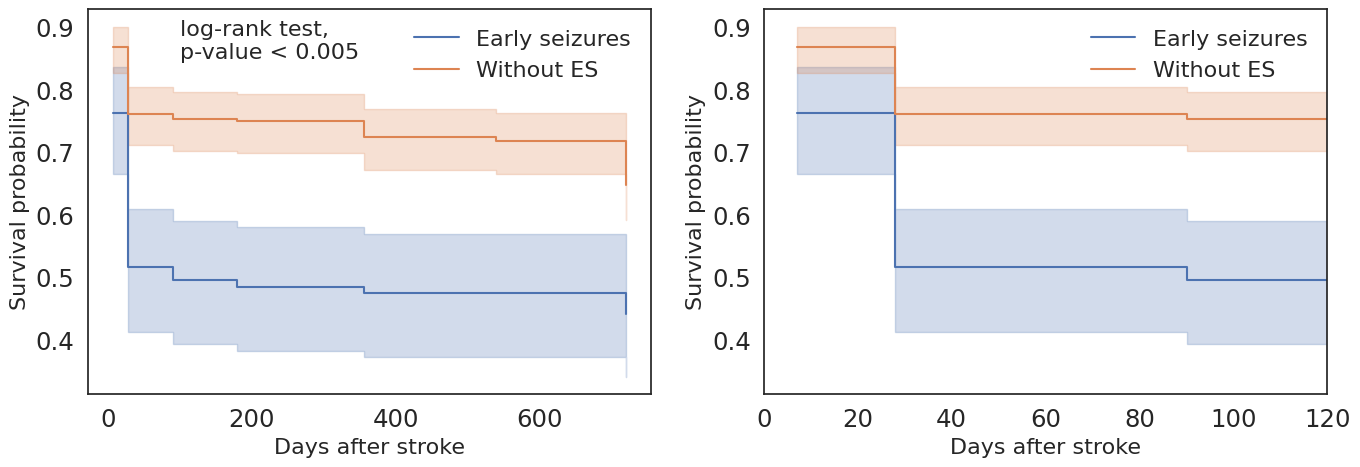

In [ ]:
sns.set(font_scale = 1.6)
sns.set_style('white')
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (16, 5))
KMF1=lifelines.KaplanMeierFitter()
KMF1.fit(durations=df_es.mort_date, event_observed=df_es.mort_outcome, label='Early seizures')
KMF1.timeline=KMF.timeline[1:]
KMF2=lifelines.KaplanMeierFitter()
KMF2.fit(durations=df_norm.mort_date, event_observed=df_norm.mort_outcome, label='Without ES')
KMF2.timeline=KMF.timeline[1:]
KMF1.plot(ax = ax[0])
KMF2.plot(ax = ax[0])
KMF1.plot(ax = ax[1])
KMF2.plot(ax = ax[1])
ax[0].legend(fontsize = 16, frameon = False)
ax[0].set_xlabel('Days after stroke', fontsize=16)
ax[0].set_ylabel('Survival probability', fontsize=16)
ax[1].legend(fontsize = 16, frameon = False)
ax[1].set_xlabel('Days after stroke', fontsize=16)
ax[1].set_ylabel('Survival probability', fontsize=16)
ax[0].text(100, 0.85, "log-rank test,\np-value < 0.005", fontsize = 16)
ax[1].set_xlim(0, 120)

plt.savefig('SuppFig2.png', bbox_inches='tight', dpi=600)